In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy as sp
import scipy.stats
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import re
res_digit = r'[0-9]'

# fourier transform
from scipy.fft import fft, ifft

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE



In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

from predicament.utils.config import DREEM_EEG_CHANNELS

In [5]:
from predicament.data.timeseries import create_participant_data_edf_only
from predicament.data.windowed import window_all_participants_data
from predicament.data.windowed import merge_condition_data
from predicament.data.partitioning import between_subject_cv_partition

from predicament.data.features import MAXIMAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import convert_timeseries_to_features
from prepare_evaluation_data import load_dataframe_and_config


## Load featured data

In [55]:
featured_df, featured_config = load_dataframe_and_config(
    '../data/featured/20231206193533/', 'featured.csv')
data_format = featured_config['LOAD']['data_format']
print(f"data_format: {data_format}")
n_channels = int(featured_config['LOAD']['n_channels'])
channels = json.loads(featured_config['LOAD']['channels'].replace("'",'"'))
participant_list = json.loads(featured_config['LOAD']['participant_list'].replace("'",'"'))
Fs = int(featured_config['LOAD']['sample_rate'])
window_size = int(featured_config['LOAD']['window_size'])
window_step = int(featured_config['LOAD']['window_step'])
time = window_size/Fs
print(f"Fs: {Fs}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")
window_overlap_factor = window_size//window_step
print(f"window_size: {window_size}, window_step: {window_step}, window_overlap_factor: {window_overlap_factor}")

data_format: E4
Fs: 64, n_samples = 256, time: 4.0s, n_channels: 7
window_size: 256, window_step: 32, window_overlap_factor: 8


In [7]:
featured_df.columns

Index(['part_ID', 'condition', 'start time', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'Mean4', 'Mean5', 'Mean6',
       ...
       'FreqSkewness4', 'FreqSkewness5', 'FreqSkewness6', 'FreqKurtosis0',
       'FreqKurtosis1', 'FreqKurtosis2', 'FreqKurtosis3', 'FreqKurtosis4',
       'FreqKurtosis5', 'FreqKurtosis6'],
      dtype='object', length=150)

In [8]:
features_to_use = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
      'Energy', 'IQR', # 'Entropy',
     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis' # , 'EnergyBands'
    ])
columns_to_use = [ col for col in featured_df.columns if re.sub(res_digit, '', col) in features_to_use ]
print(f"columns_to_use = {columns_to_use}")

designmtx = featured_df[columns_to_use].values 
condition_data = featured_df['condition'].values.astype(int)
subject_data_names = featured_df['part_ID']

design2d = TSNE(n_components=2, init='random', perplexity=3).fit_transform(designmtx)
print(f"design2d.shape = {design2d.shape}")

columns_to_use = ['Mean0', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'Mean5', 'Mean6', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'SD5', 'SD6', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'MAD4', 'MAD5', 'MAD6', 'Max0', 'Max1', 'Max2', 'Max3', 'Max4', 'Max5', 'Max6', 'Min0', 'Min1', 'Min2', 'Min3', 'Min4', 'Min5', 'Min6', 'Energy0', 'Energy1', 'Energy2', 'Energy3', 'Energy4', 'Energy5', 'Energy6', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'IQR4', 'IQR5', 'IQR6', 'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'Correlation6', 'Correlation7', 'Correlation8', 'Correlation9', 'Correlation10', 'Correlation11', 'Correlation12', 'Correlation13', 'Correlation14', 'Correlation15', 'Correlation16', 'Correlation17', 'Correlation18', 'Correlation19', 'Correlation20', 'arCoeff0', 'arCoeff1', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff16', 'arCoeff17'

designmtx.shape = (25296, 126)
condition_data.shape = (25296,)
subject_data.shape = (25296,)


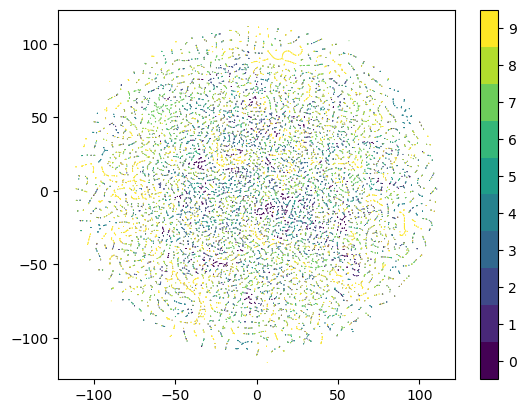

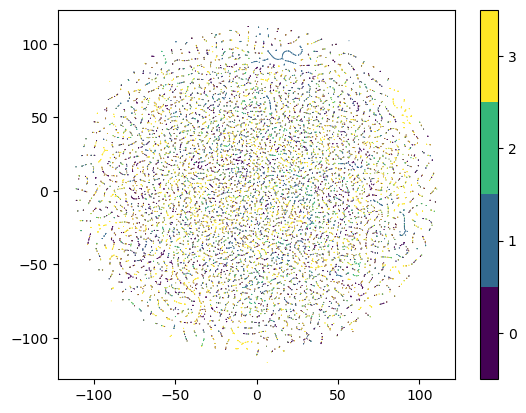

In [9]:
subjects = np.unique(subject_data_names)
subject_data = np.empty(subject_data_names.shape, dtype=int)
for s, sub in enumerate(subjects):
    subject_data[subject_data_names==sub] = s
print(f"designmtx.shape = {designmtx.shape}")
print(f"condition_data.shape = {condition_data.shape}")
print(f"subject_data.shape = {subject_data.shape}")
    
conditions = np.unique(condition_data)
markers = ['v', '^', '<', '>', 's', '*', '+' , 'x', 'D', '.']
colours = ['b','g','r','y','k']
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(np.min(subject_data)-0.5,np.max(subject_data)+0.5), cmap.N)

plt.scatter(
    design2d[:,0], design2d[:,1], c=subject_data, norm=norm, s=0.5, edgecolor='none')
plt.colorbar(
    ticks=np.arange(subjects.size))
plt.title("2d TSNE data coloured by subject id")


plt.figure()
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(np.min(condition_data)-0.5,np.max(condition_data)+0.5), cmap.N)

plt.scatter(
    design2d[:,0], design2d[:,1], c=condition_data, norm=norm, s=0.5, edgecolor='none')
plt.colorbar(
    ticks=np.arange(conditions.size))
plt.title("2d TSNE data coloured by condition id")
        

## Classification

In [62]:
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import GroupKFold

models = {
    "Random Forest": RandomForestClassifier(
        min_samples_leaf=5, random_state=0
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        max_leaf_nodes=15, random_state=0
    ),
    "MLP":  MLPClassifier(max_iter=100)
}
param_grids = {
    "Random Forest": {"n_estimators": [10, 20, 50, 100]},
    "Gradient Boosting": {"n_estimators": [10, 20, 50, 100]},
    "MLP": {
        'hidden_layer_sizes': [(10,),(20,),(50,),(100,)],
        'activation': ['relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
}



In [11]:
# # standard cross-validation
# # Match all digits in the string and replace them with an empty string
# # new_string = re.sub(pattern, '', string1)
# results_df = None

# features_to_use = set(
#     ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
#       'Energy', 'IQR', # 'Entropy',
#      'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
#     'FreqKurtosis' # , 'EnergyBands'
#     ])
# columns_to_use = [ col for col in featured_df.columns if re.sub(res_digit, '', col) in features_to_use ]
# print(f"columns_to_use = {columns_to_use}")

# designmtx = featured_df[columns_to_use].values 
# # condition_data = featured_df['condition'].values.astype(int)
# # subject_data = featured_df['subject'].values.astype(int)

# cv = KFold(n_splits=5, shuffle=True, random_state=0)
# results = []
# for name, model in models.items():
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grids[name],
#         return_train_score=True,
#         cv=cv,
#     ).fit(designmtx, condition_data)
#     result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
#     results.append(result)

In [12]:
# print(f"results[0]['mean_test_score'] ={results[0]['mean_test_score']}")
# print(f"results[1]['mean_test_score'] ={results[1]['mean_test_score']}")


## Hold one group out

In [15]:
# standard cross-validation
# Match all digits in the string and replace them with an empty string
# new_string = re.sub(pattern, '', string1)
subjects = np.unique(featured_df['part_ID'])
n_subjects = len(subjects)
groups = np.empty(len(featured_df), dtype=int)
for s, sub in enumerate(subjects):
    groups[featured_df['part_ID']==sub] = s
    
features_to_use = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
      'Energy', 'IQR', # 'Entropy',
     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis' # , 'EnergyBands'
    ])
columns_to_use = [ col for col in featured_df.columns if re.sub(res_digit, '', col) in features_to_use ]
print(f"columns_to_use = {columns_to_use}")

designmtx = featured_df[columns_to_use].values 

columns_to_use = ['Mean0', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'Mean5', 'Mean6', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'SD5', 'SD6', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'MAD4', 'MAD5', 'MAD6', 'Max0', 'Max1', 'Max2', 'Max3', 'Max4', 'Max5', 'Max6', 'Min0', 'Min1', 'Min2', 'Min3', 'Min4', 'Min5', 'Min6', 'Energy0', 'Energy1', 'Energy2', 'Energy3', 'Energy4', 'Energy5', 'Energy6', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'IQR4', 'IQR5', 'IQR6', 'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'Correlation6', 'Correlation7', 'Correlation8', 'Correlation9', 'Correlation10', 'Correlation11', 'Correlation12', 'Correlation13', 'Correlation14', 'Correlation15', 'Correlation16', 'Correlation17', 'Correlation18', 'Correlation19', 'Correlation20', 'arCoeff0', 'arCoeff1', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff16', 'arCoeff17'

In [18]:
results_df = pd.DataFrame()
group_kfold = GroupKFold(n_splits=n_subjects)
results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=group_kfold,
    ).fit(X=designmtx, y=condition_data, groups=groups)
    result_df = pd.DataFrame(grid_search.cv_results_)
    #test_df['model'] = result['model']
    result_df.insert(0, 'model', name)
    result_df.insert(1, 'held out', 'subject')
    result_df.insert(2, 'feature set', str(features_to_use))
    display(result_df)
    results_df = pd.concat((results_df, result_df))
    #result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    #results.append(result)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,mean_train_score,std_train_score
0,1.727008,0.109214,0.003263,0.000247,10,{'n_estimators': 10},0.312294,0.137428,0.165067,0.373843,...,0.999956,0.999956,0.999869,0.999913,0.999914,0.999914,0.999957,1.0,0.999925,0.000060
1,3.557173,0.191692,0.005240,0.000442,20,{'n_estimators': 20},0.317064,0.140115,0.111708,0.344467,...,1.000000,0.999956,0.999956,1.000000,1.000000,0.999914,0.999871,1.0,0.999960,0.000051
2,9.277215,0.505570,0.011663,0.002161,50,{'n_estimators': 50},0.324771,0.170825,0.105566,0.413280,...,1.000000,1.000000,0.999956,1.000000,1.000000,0.999914,0.999957,1.0,0.999984,0.000028
3,18.692663,0.872094,0.022053,0.002187,100,{'n_estimators': 100},0.331743,0.183493,0.102879,0.370624,...,1.000000,1.000000,0.999913,1.000000,1.000000,0.999957,0.999957,1.0,0.999984,0.000028


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,mean_train_score,std_train_score
0,45.060295,0.806146,0.002625,0.000244,10,{'n_estimators': 10},0.313394,0.135509,0.126679,0.115091,...,0.741704,0.731095,0.741494,0.796583,0.735495,0.755686,0.739383,0.693101,0.739184,0.024653
1,90.022423,1.528526,0.003470,0.000364,20,{'n_estimators': 20},0.302018,0.100192,0.147793,0.122736,...,0.914340,0.862391,0.888782,0.898529,0.883785,0.889819,0.865837,0.872964,0.881420,0.015746
2,221.498645,3.094736,0.005856,0.000669,50,{'n_estimators': 50},0.306422,0.137044,0.129367,0.145674,...,0.978694,0.977730,0.979394,0.975303,0.985797,0.980752,0.982944,0.977186,0.979487,0.002779
3,441.484608,6.170032,0.009805,0.001334,100,{'n_estimators': 100},0.290642,0.113244,0.158541,0.142052,...,0.998904,0.998159,0.998040,0.997708,0.999137,0.998231,0.997416,0.998022,0.998142,0.000468


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,params,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,mean_train_score,std_train_score
0,5.391431,0.692859,0.004324,0.000447,tanh,0.0001,"(10,)",constant,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.345930,0.342028,0.338314,0.337413,0.344068,0.342540,0.338617,0.364482,0.344390,0.007319
1,3.117892,0.624719,0.004602,0.001379,tanh,0.0001,"(10,)",constant,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.333085,0.346763,0.336659,0.330839,0.333319,0.332571,0.335042,0.362335,0.340054,0.009149
2,5.911544,0.120234,0.004430,0.000502,tanh,0.0001,"(10,)",adaptive,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.345184,0.341765,0.343585,0.343772,0.336643,0.336239,0.341761,0.362630,0.344699,0.006883
3,3.227176,1.059662,0.004337,0.000505,tanh,0.0001,"(10,)",adaptive,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.328701,0.338170,0.338140,0.335381,0.324080,0.325968,0.321604,0.351054,0.334721,0.009895
4,15.985442,1.628323,0.006800,0.000782,tanh,0.0001,"(20,)",constant,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.350840,0.346631,0.347375,0.340917,0.343680,0.343188,0.347747,0.365492,0.348394,0.006332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,3.843063,1.047191,0.006097,0.004600,relu,0.05,"(50,)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",...,0.345097,0.226338,0.283032,0.217431,0.277327,0.274740,0.168232,0.239130,0.248310,0.056151
60,2.516756,0.067737,0.005507,0.000647,relu,0.05,"(100,)",constant,sgd,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",...,0.329096,0.329096,0.327031,0.323832,0.324080,0.323983,0.324016,0.351054,0.329678,0.007756
61,6.834012,1.508525,0.006137,0.000712,relu,0.05,"(100,)",constant,adam,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",...,0.248214,0.319451,0.319408,0.207050,0.198411,0.248371,0.217245,0.248811,0.251702,0.038026
62,13.989867,0.222082,0.005583,0.000686,relu,0.05,"(100,)",adaptive,sgd,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",...,0.329096,0.329096,0.327031,0.323832,0.324080,0.323983,0.323757,0.351054,0.329658,0.007777


In [19]:
results_df

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split8_train_score,split9_train_score,split10_train_score,mean_train_score,std_train_score,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver
0,Random Forest,subject,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",1.727008,0.109214,0.003263,0.000247,10,{'n_estimators': 10},0.312294,...,0.999914,0.999957,1.000000,0.999925,0.000060,NaN,NaN,NaN,NaN,NaN
1,Random Forest,subject,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",3.557173,0.191692,0.005240,0.000442,20,{'n_estimators': 20},0.317064,...,0.999914,0.999871,1.000000,0.999960,0.000051,NaN,NaN,NaN,NaN,NaN
2,Random Forest,subject,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",9.277215,0.505570,0.011663,0.002161,50,{'n_estimators': 50},0.324771,...,0.999914,0.999957,1.000000,0.999984,0.000028,NaN,NaN,NaN,NaN,NaN
3,Random Forest,subject,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",18.692663,0.872094,0.022053,0.002187,100,{'n_estimators': 100},0.331743,...,0.999957,0.999957,1.000000,0.999984,0.000028,NaN,NaN,NaN,NaN,NaN
0,Gradient Boosting,subject,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",45.060295,0.806146,0.002625,0.000244,10,{'n_estimators': 10},0.313394,...,0.755686,0.739383,0.693101,0.739184,0.024653,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,MLP,subject,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",3.843063,1.047191,0.006097,0.004600,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.289541,...,0.274740,0.168232,0.239130,0.248310,0.056151,relu,0.05,"(50,)",adaptive,adam
60,MLP,subject,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",2.516756,0.067737,0.005507,0.000647,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.305688,...,0.323983,0.324016,0.351054,0.329678,0.007756,relu,0.05,"(100,)",constant,sgd
61,MLP,subject,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",6.834012,1.508525,0.006137,0.000712,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.273028,...,0.248371,0.217245,0.248811,0.251702,0.038026,relu,0.05,"(100,)",constant,adam
62,MLP,subject,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",13.989867,0.222082,0.005583,0.000686,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.305688,...,0.323983,0.323757,0.351054,0.329658,0.007777,relu,0.05,"(100,)",adaptive,sgd


In [20]:
import datetime
nowstr = datetime.datetime.now().replace(microsecond=0).isoformat()
results_df.to_csv(f'../data/results/{nowstr}_results.csv')

In [ ]:
for name, model in models.items():
    print(name)

In [21]:
results_df[results_df['model'] == 'MLP']['mean_test_score'].max()

0.3252334560211044

In [22]:
results_df[results_df['model'] == 'Random Forest']['mean_test_score'].max()

0.2103309706853234

In [23]:
results_df[results_df['model'] == 'Gradient Boosting']['mean_test_score'].max()

0.22073879968138532

In [26]:
d = dict(results_df[results_df['mean_test_score'] == 0.3252334560211044]['params'])

In [28]:
d[62]

{'activation': 'relu',
 'alpha': 0.05,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'solver': 'sgd'}

## Held out subject-conditions

In [43]:
subject_conditions = [(s,c) for s in subjects for c in conditions]
subject_conditions
featured_df['subject_conditions'] = None
for i, (s, c) in enumerate(subject_conditions):
    featured_df['subject_conditions'][(featured_df['part_ID'] == s) & (featured_df['condition'] == c)] = i
featured_df['subject_conditions']

/tmp/ipykernel_2619040/2314584131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_df['subject_conditions'][(featured_df['part_ID'] == s) & (featured_df['condition'] == c)] = i


0         0
1         0
2         0
3         0
4         0
         ..
25291    52
25292    52
25293    52
25294    52
25295    52
Name: subject_conditions, Length: 25296, dtype: object

In [41]:
featured_df.columns

Index(['part_ID', 'condition', 'start time', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'Mean4', 'Mean5', 'Mean6',
       ...
       'FreqSkewness5', 'FreqSkewness6', 'FreqKurtosis0', 'FreqKurtosis1',
       'FreqKurtosis2', 'FreqKurtosis3', 'FreqKurtosis4', 'FreqKurtosis5',
       'FreqKurtosis6', 'subject_conditions'],
      dtype='object', length=151)

In [44]:
sc_groups = featured_df['subject_conditions'].to_numpy()
sc_results_df = pd.DataFrame()
sc_group_kfold = GroupKFold(n_splits=n_subjects)
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=sc_group_kfold,
    ).fit(X=designmtx, y=condition_data, groups=sc_groups)
    result_df = pd.DataFrame(grid_search.cv_results_)
    #test_df['model'] = result['model']
    result_df.insert(0, 'model', name)
    result_df.insert(1, 'held out', 'subject_condition')
    result_df.insert(2, 'feature set', str(features_to_use))
    display(result_df)
    sc_results_df = pd.concat((sc_results_df, result_df))
    #result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    #results.append(result)

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,mean_train_score,std_train_score
0,Random Forest,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",1.944634,0.071772,0.003862,0.000435,10,{'n_estimators': 10},0.022887,...,0.999696,0.999913,0.999957,0.999870,0.999738,0.999912,0.999957,0.999826,0.999869,0.000085
1,Random Forest,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",3.894085,0.133601,0.006035,0.000211,20,{'n_estimators': 20},0.012764,...,0.999826,0.999957,0.999913,0.999826,0.999826,0.999956,0.999957,1.000000,0.999917,0.000060
2,Random Forest,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",9.802400,0.312887,0.012920,0.000545,50,{'n_estimators': 50},0.036092,...,0.999913,0.999957,1.000000,0.999957,1.000000,0.999956,1.000000,1.000000,0.999968,0.000033
3,Random Forest,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",19.649832,0.678204,0.024606,0.001134,100,{'n_estimators': 100},0.040493,...,0.999957,0.999957,1.000000,0.999957,1.000000,0.999956,1.000000,1.000000,0.999976,0.000022


,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,mean_train_score,std_train_score
0,Gradient Boosting,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",49.306198,0.306163,0.002814,0.000120,10,{'n_estimators': 10},0.016725,...,0.773998,0.766167,0.752731,0.768244,0.756401,0.740703,0.715060,0.721905,0.747140,0.022016
1,Gradient Boosting,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",97.861230,0.623796,0.003814,0.000417,20,{'n_estimators': 20},0.006162,...,0.892553,0.888889,0.913965,0.898379,0.874253,0.887653,0.882233,0.903711,0.891517,0.010421
2,Gradient Boosting,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",245.152421,1.508024,0.006267,0.000285,50,{'n_estimators': 50},0.006162,...,0.981427,0.985866,0.987647,0.988091,0.979500,0.979064,0.981131,0.982513,0.981185,0.004827
3,Gradient Boosting,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",490.308032,1.244916,0.010854,0.000474,100,{'n_estimators': 100},0.000440,...,0.998872,0.999261,0.999393,0.999435,0.996423,0.998423,0.998438,0.997820,0.998441,0.000932


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,mean_train_score,std_train_score
0,MLP,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",6.128386,0.713966,0.004702,0.000265,tanh,0.0001,"(10,)",...,0.342605,0.339030,0.343317,0.349024,0.348803,0.345670,0.332827,0.353408,0.346846,0.010543
1,MLP,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",3.205811,1.148271,0.005772,0.001819,tanh,0.0001,"(10,)",...,0.325768,0.329811,0.332438,0.338114,0.329219,0.339933,0.331222,0.348655,0.337449,0.012099
2,MLP,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",6.676086,0.095269,0.005701,0.002068,tanh,0.0001,"(10,)",...,0.338440,0.343770,0.336122,0.347851,0.340079,0.346546,0.336211,0.355807,0.345054,0.010367
3,MLP,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",3.051086,1.030757,0.005278,0.001567,tanh,0.0001,"(10,)",...,0.347075,0.326071,0.328407,0.334985,0.342914,0.328720,0.328967,0.344032,0.336847,0.010974
4,MLP,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",22.086822,2.926954,0.007790,0.002127,tanh,0.0001,"(20,)",...,0.348898,0.350120,0.350988,0.347938,0.350678,0.353730,0.330658,0.357028,0.350206,0.009550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,MLP,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",5.520941,2.843199,0.005557,0.001423,relu,0.05,"(50,)",...,0.219233,0.334203,0.171463,0.253140,0.298164,0.343612,0.319858,0.324016,0.277114,0.054524
60,MLP,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",3.924149,0.203065,0.009460,0.002191,relu,0.05,"(100,)",...,0.325768,0.326462,0.325373,0.326292,0.327431,0.328807,0.326147,0.332607,0.329706,0.010645
61,MLP,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",10.040437,2.868709,0.008324,0.001502,relu,0.05,"(100,)",...,0.316742,0.280017,0.312803,0.322902,0.218214,0.358504,0.222521,0.253456,0.274926,0.049199
62,MLP,subject_condition,"{'Max', 'Energy', 'IQR', 'SD', 'Min', 'Mean', ...",19.145750,3.693529,0.006832,0.000956,relu,0.05,"(100,)",...,0.325768,0.326462,0.325503,0.326292,0.331487,0.329683,0.326147,0.332607,0.330276,0.010523


In [45]:
import datetime
nowstr = datetime.datetime.now().replace(microsecond=0).isoformat()
results_df.to_csv(f'../data/results/{nowstr}_results.csv')

In [47]:
for model in np.unique(sc_results_df['model']):
    model_max_test_score = sc_results_df[sc_results_df['model'] == model]['mean_test_score'].max()
    print(f"{model}: max_test_score= {model_max_test_score}")
    d = sc_results_df[sc_results_df['mean_test_score'] == model_max_test_score]['params']
    for k,v in d.items():
        model_best_params = v
        print(f"best params: {v}")
    print()

Gradient Boosting: max_test_score= 0.07204819146612047
best params: {'n_estimators': 20}

MLP: max_test_score= 0.3324038724503557
best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'sgd'}

Random Forest: max_test_score= 0.048169095406419844
best params: {'n_estimators': 100}



## Held out subject-condition-phases

In [60]:
for part_ID in subjects:
    for condition in conditions:
        _filter = (featured_df['condition'] == condition) & (featured_df['part_ID'] == part_ID)
        sc_featured_df = featured_df[_filter]
        min_time_index = sc_featured_df['start time'].min() 
        max_time_index = sc_featured_df['start time'].max()
        mid_time_index = (min_time_index+max_time_index)//2
        margin = window_overlap_factor//2
        if (margin*2) < window_overlap_factor:
            margin += 1
        phase1_start_index = min_time_index
        phase1_end_index = mid_time_index-margin
        phase2_start_index = mid_time_index+margin
        phase2_end_index = max_time_index
        print(f"part_ID: {part_ID}, condition: {condition}")
        print(f"min: {min_time_index}, max: {max_time_index}, mid: {mid_time_index}")
        if phase1_start_index < phase1_end_index:
            print(f"phase1_start_index: {phase1_start_index}, phase1_end_index: {phase1_end_index}")
            print(f"phase2_start_index: {phase2_start_index}, phase2_end_index: {phase2_end_index}")
        print()

part_ID: VG_01, condition: 0
min: 0, max: 0, mid: 0

part_ID: VG_01, condition: 1
min: 121088, max: 241920, mid: 181504
phase1_start_index: 121088, phase1_end_index: 181500
phase2_start_index: 181508, phase2_end_index: 241920

part_ID: VG_01, condition: 2
min: 363264, max: 484096, mid: 423680
phase1_start_index: 363264, phase1_end_index: 423676
phase2_start_index: 423684, phase2_end_index: 484096

part_ID: VG_01, condition: 3
min: 242176, max: 363008, mid: 302592
phase1_start_index: 242176, phase1_end_index: 302588
phase2_start_index: 302596, phase2_end_index: 363008

part_ID: VG_01, condition: 4
min: 0, max: 120832, mid: 60416
phase1_start_index: 0, phase1_end_index: 60412
phase2_start_index: 60420, phase2_end_index: 120832

part_ID: VG_03, condition: 0
min: 0, max: 0, mid: 0

part_ID: VG_03, condition: 1
min: 90368, max: 119040, mid: 104704
phase1_start_index: 90368, phase1_end_index: 104700
phase2_start_index: 104708, phase2_end_index: 119040

part_ID: VG_03, condition: 2
min: 24038

Available objects for config:
    AliasManager
    DisplayFormatter
    HistoryManager
    IPCompleter
    IPKernelApp
    InlineBackend
    LoggingMagics
    MagicsManager
    OSMagics
    PrefilterManager
    ScriptMagics
    StoreMagics
    ZMQInteractiveShell


In [61]:
tot = len(featured_df)
for c in np.unique(featured_df['condition']):
    count = len(featured_df[featured_df['condition'] == c])
    print(f"count = {count}")
    print(f"{c} : {count}/{tot} = {count/tot}")

count = 8340
0 : 8340/25296 = 0.32969639468690703
count = 4543
1 : 4543/25296 = 0.17959361163820367
count = 2951
2 : 2951/25296 = 0.11665876027830487
count = 5339
3 : 5339/25296 = 0.21106103731815307
count = 4123
4 : 4123/25296 = 0.16299019607843138
